In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it

import scTrans
from scTrans import scTranslate

## KL divergence

https://arxiv.org/pdf/1312.6114.pdf

In [89]:
scrna=sc.read_h5ad("/Users/yaoestelle/scRNA_mit.h5ad")

In [90]:
sample2response={'620':'PD', '776_on':'PD','856_A':'PD','856_B':'PD',
                 '1224_post-FT':'PD', '1224_post-Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227_pre':'R',
                 '1009_on':'R',
                 '1130':'R'}
num2name={1:'malignant',2:'Endothelial',3:'T cell', 4:'macrophage',5:'malignant',
          6:'B cell', 7: 'malignant', 8:'CAF',9:'Dendritic',10:'Plasma B'} ##11:NK

scrna.obs['response']=scrna.obs['orig.ident'].map(sample2response)
scrna.obs['annotated_celltype']=scrna.obs['dbscan'].map(num2name)

In [91]:
scrna_full=scrna.X
scrna_label=scrna.obs[['dbscan','response','annotated_celltype']]

In [156]:
##Train test split
validation_percent = 0.20
x_train, test_x, y_train, test_y  = train_test_split(scrna_full, scrna_label,
                                                     test_size=validation_percent,
                                                     stratify = scrna_label)
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train,
                                                  test_size=validation_percent,
                                                  stratify=y_train)

### Past model code 

In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [29]:
class FNN_VAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim, n_feature):
        super(FNN_VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense(250, activation='relu'),
                tf.keras.layers.Dense(100, activation='relu'),
                tf.keras.layers.Dense(100, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(100, activation='relu'),
                tf.keras.layers.Dense(100, activation='relu'),
                tf.keras.layers.Dense(100, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [49]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)


def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    reconstruction = model.decode(z)
    
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(test_x - reconstruction),1))
    
    kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    
    return total_loss

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


### New implementation of FNN VAE 

In [94]:
class FNN_VAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim, n_feature, network_architecture, optimizer,
                 learning_rate, lambda_reconstruct, lambda_kl
                ):
        super(FNN_VAE, self).__init__()
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        if optimizer == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        if optimizer == 'Rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if optimizer == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate)
                
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense( self.hidden_encode1, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode2, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(self.hidden_decode1, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode2, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )
    
    ##Sample is called for prediction
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        reconstruct = self.decoder(z)
        return reconstruct

In [122]:
def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    reconstruction = model.decode(z)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction),1))
    
    kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    
    total_loss = model.lambda_reconstruct*reconstruction_loss + model.lambda_kl*kl_loss
    
    return total_loss

#@tf.function
def train_step(model, x):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return(loss)

In [330]:
##Initialize model 
def initialize_model(X, n_latent, optimizer,
                    learning_rate = 1e-4, 
                    lambda_latent = 1e-2, lambda_reconst = 1e-3):
    
    model=FNN_VAE(latent_dim=n_latent, 
                  n_feature=X.shape[1], 
                  network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                        "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                        "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                  optimizer = optimizer,
                  learning_rate= learning_rate, 
                  lambda_reconstruct= lambda_reconst, 
                  lambda_kl= lambda_latent)
    
    return model

In [147]:
def scRNA_train(model, x_train, y_train, x_val, y_val ,num_epochs, batch_size):
    
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(2)]
    
    history_train={'latent':[], 'cost':[], 'y_train':[]}
    history_val={'latent':[], 'cost':[]}
    history_weight=[]
    
    for epoch in range(num_epochs):
        
        ##Shuffle data per epoch
        shuffle_index=np.arange(x_train.shape[0])
        np.random.shuffle(shuffle_index)
        shuffle_x = x_train[shuffle_index]
        shuffle_y = y_train.iloc[shuffle_index]
        #shuffle_y=y_train[shuffle_index]
        
        total_batch = int(x_train.shape[0] / batch_size)
        pbars[1].reset(total=total_batch)
        
        for step in range(total_batch):
            
            offset = (step * batch_size) % (x_train.shape[0] - batch_size)
            batch_x = shuffle_x[offset:(offset + batch_size), :]
            
            ##training step 
            loss = train_step(model, batch_x)
            
            pbars[1].update()
        
        ##Latent space for training set 
        train_latent, _ = model.encode(shuffle_x)
        history_train['latent'].append(train_latent)
        history_train['cost'].append(loss)
        history_train['y_train'].append(shuffle_y)
        
        ##Keep track of the first embedding for feautre importance 
        ##Shape = n_feature (genes) * first hidden layer size 
        history_weight.append(model.trainable_variables[0])
        
        pbars[0].update()
        
        ##Latent space for validation set
        val_latent, _ = model.encode(x_val)
        history_val['latent'].append( val_latent )
        val_cost =  compute_loss(model, x_val) 
        history_val['cost'].append(val_cost)
        
        print(f"Epoch: {epoch}, Train loss: {loss}, Validation loss: {val_cost}")
        
    return history_train , history_val , history_weight

In [165]:
def scRNA_loss(history_train, history_val):
    
    ###Loss function trajectory
    train_cost = history_train['cost']
    val_cost = history_val['cost']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(train_cost)),train_cost)
    ax[0].plot(np.arange(len(train_cost)),train_cost)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss (Reconstruction + Latent Loss)", fontsize=14)
    
    ax[1].scatter(np.arange(len(val_cost)),val_cost)
    ax[1].plot(np.arange(len(val_cost)),val_cost)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Validation loss", fontsize=12)
    ax[1].set_title("Validation loss (Reconstruction Loss)", fontsize=14)
    
    fig.suptitle("Visualization of loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [181]:
def scRNA_silhouette(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Calculate silhouette score per sample
    train_sil=silhouette_samples(train_latent, train_y['dbscan'].values)
    val_sil=silhouette_samples(val_latent, val_y['dbscan'].values)
    
    n_clusters=len(Counter(train_y['dbscan'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    for i in range(1,n_clusters+1):
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[train_y['dbscan'].values == i]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[val_y['dbscan'].values == i]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, val_y_lower + 0.5 * val_size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, train_y['dbscan'].values)
    val_avg=silhouette_score(val_latent, val_y['dbscan'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for VAE latent space", fontsize=14, fontweight='bold')
    plt.show()           

In [177]:
def scRNA_latent(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    train_adata = AnnData(train_latent) 
    
    train_adata.obs = train_y
    train_adata.obs['dbscan'] = pd.Categorical(train_adata.obs['dbscan'])
    train_adata.obs['annotated_celltype'] = pd.Categorical(train_adata.obs['annotated_celltype'])
    train_adata.obs['response'] = pd.Categorical(train_adata.obs['response'])
    
    sc.pp.neighbors(train_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(train_adata)
    sc.pl.umap(train_adata, color=['dbscan','response'],legend_loc='on data',
               size=50, title=["Training embedding by cell type", "Training embedding by response"])
    
    val_adata = AnnData(val_latent)
    
    val_adata.obs = val_y
    val_adata.obs['dbscan'] = pd.Categorical(val_adata.obs['dbscan'])
    val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
    val_adata.obs['response'] = pd.Categorical(val_adata.obs['response'])
    
    sc.pp.neighbors(val_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(val_adata)
    sc.pl.umap(val_adata, color=['dbscan','response'],legend_loc='on data',
               size=50, title=["Validation embedding by cell type", "Validation embedding by response"])

In [258]:
def scRNA_latent_pca(history_train, history_val, val_y , epoch_num):
    ###Latent space 
    
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.index=train_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([train_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="dbscan", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    
    f.suptitle("Visualization of training PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(val_latent)
    pca_df=pd.DataFrame(pca.transform(val_latent))
    pca_df.index=val_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([val_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="dbscan", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    
    f.suptitle("Visualization of validation PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [327]:
def feature_importance(history_weight, epoch_num):
    
    weight=history_weight[epoch_num].numpy()
    
    pca = PCA(n_components=2)
    pca.fit(weight.T)
    pca_df=pd.DataFrame(pca.transform(weight.T))
    
    loading=pd.DataFrame(pca.components_.T)
    loading.columns=['PC1','PC2']
    loading['gene']=list(scrna.var.index)
    
    print("PC1 top 5 loading genes")
    loading=loading.sort_values(by=['PC1'])
    display(pd.DataFrame(loading.iloc[:5,2]))
    display(pd.DataFrame(loading.iloc[loading.shape[0]-5:loading.shape[0],2]))
    
    print("PC2 top 5 loading genes")
    loading=loading.sort_values(by=['PC2'])
    display(pd.DataFrame(loading.iloc[:5,2]))
    display(pd.DataFrame(loading.iloc[loading.shape[0]-5:loading.shape[0],2]))

In [200]:
num_epochs=10
batch_size=64
n_latent=50

In [201]:
model = initilize_model(x_train, n_latent, optimizer = 'SGD',
                        learning_rate = 1e-4, 
                        lambda_latent = 1e-2, 
                        lambda_reconst = 1e-3)

In [202]:
history_train , history_val , history_weight= scRNA_train(model, 
                                                          train_x, train_y,
                                                          val_x, val_y,
                                                          20, batch_size)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.3354902267456055, Validation loss: 8.879080772399902
Epoch: 1, Train loss: 9.366119384765625, Validation loss: 8.819770812988281
Epoch: 2, Train loss: 7.9161763191223145, Validation loss: 8.786439895629883
Epoch: 3, Train loss: 11.363289833068848, Validation loss: 8.763309478759766
Epoch: 4, Train loss: 9.275696754455566, Validation loss: 8.746589660644531
Epoch: 5, Train loss: 11.648261070251465, Validation loss: 8.73249340057373
Epoch: 6, Train loss: 7.810999870300293, Validation loss: 8.720925331115723
Epoch: 7, Train loss: 8.07209587097168, Validation loss: 8.71189022064209
Epoch: 8, Train loss: 8.873763084411621, Validation loss: 8.704025268554688
Epoch: 9, Train loss: 10.4989652633667, Validation loss: 8.697495460510254
Epoch: 10, Train loss: 7.301730155944824, Validation loss: 8.691597938537598
Epoch: 11, Train loss: 6.947910785675049, Validation loss: 8.68614673614502
Epoch: 12, Train loss: 8.0050687789917, Validation loss: 8.68126106262207
Epoch: 13, Tr

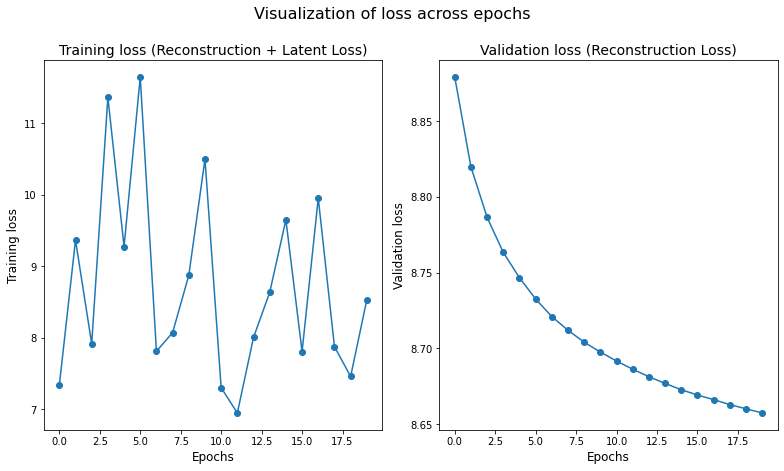

In [203]:
scRNA_loss(history_train, history_val)

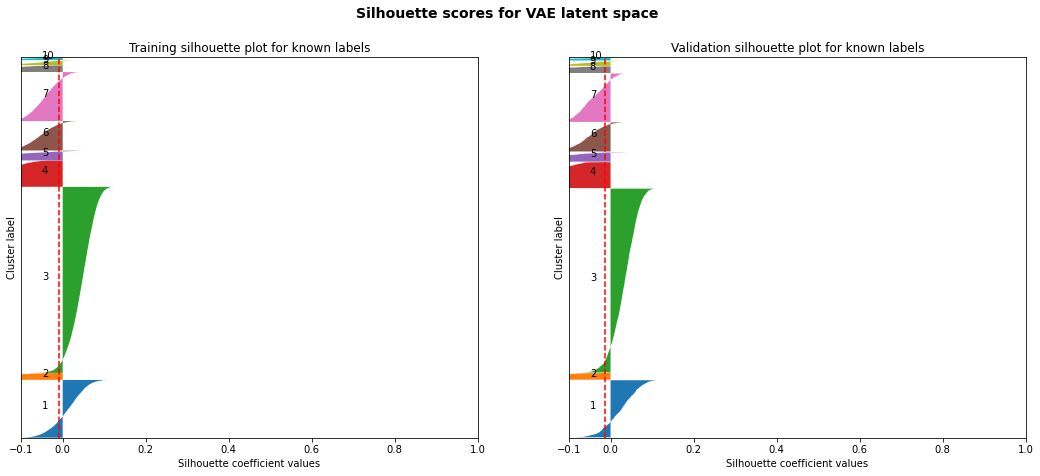

In [204]:
scRNA_silhouette(history_train, history_val, val_y , epoch_num=19)

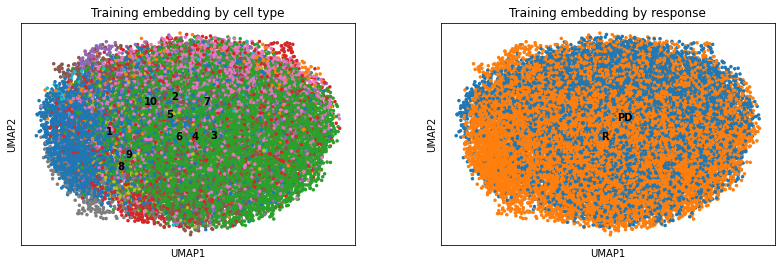

<ipython-input-177-99b1f55c5329>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['dbscan'] = pd.Categorical(val_adata.obs['dbscan'])
<ipython-input-177-99b1f55c5329>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
<ipython-input-177-99b1f55c5329>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

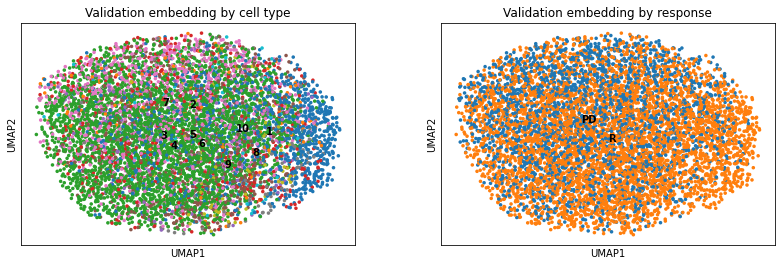

In [205]:
scRNA_latent(history_train, history_val, val_y , epoch_num=19)

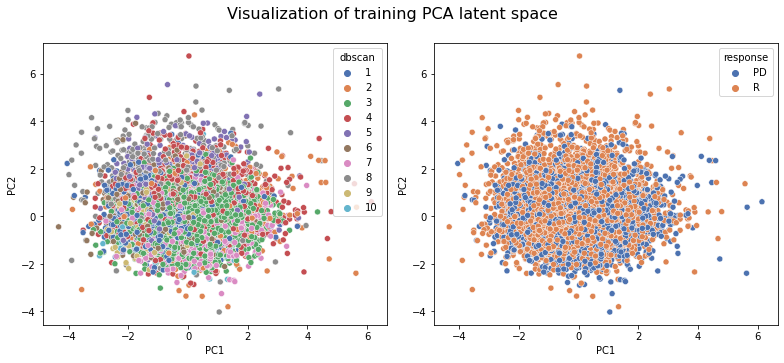

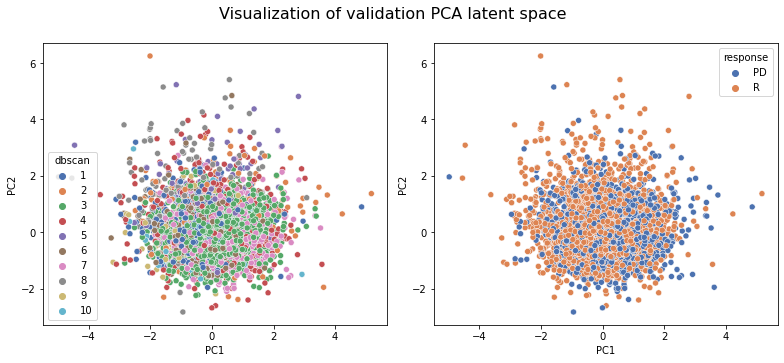

In [259]:
scRNA_latent_pca(history_train, history_val, val_y , epoch_num=19)

In [318]:
feature_importance(history_weight, 19)

PC1 top 5 loading genes


,gene
913,STK32A-AS1
2841,KIR3DL1
2846,IL11
746,MMRN1
2629,MMP9


,gene
1149,SP8
2262,LINC00926
1667,MS4A4A
1334,GAGE12F
832,EGFLAM


PC2 top 5 loading genes


,gene
348,REL
1047,PIM1
1662,FAM111B
1614,CTSD
335,CYP1B1


,gene
2487,CNTD1
585,AC106712.1
2223,IGHV2-70
1639,SPTY2D1
2540,GAPLINC


In [345]:
Hyper_grid={'n_latent':[50, 100],
            'learning_rate':[1e-3, 1e-4],
            'lambda_latent':[1e-2, 1e-1],
            'lambda_reconst_rna':[1e-3]
           }

num_epochs=20
batch_size=64

def grid_search(Hyper_grid):
    hyperparam_combos = list(it.product(Hyper_grid['n_latent'], 
                                        Hyper_grid['learning_rate'],
                                        Hyper_grid['lambda_latent'],
                                        Hyper_grid['lambda_reconst_rna']))
    
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(1)]
    pbars[0].reset(len(hyperparam_combos))
    pbars[0].set_description('Grid Search')
    
    losses=[]
    for n_latent, learning_rate, lambda_latent, lambda_reconst_rna in hyperparam_combos:
        
        print(f"Latent: {n_latent}, Learning rate: {learning_rate}, Latent reg: {lambda_latent}, Reconstruction reg: {lambda_reconst_rna}")
        model=initialize_model(train_x, 
                              n_latent, optimizer='Adam',
                              learning_rate = learning_rate, 
                              lambda_latent = lambda_latent, 
                              lambda_reconst = lambda_reconst_rna)
        
        history_train , history_val , history_weight= scRNA_train(model, 
                                                                  train_x, train_y, 
                                                                  val_x, val_y ,
                                                                  num_epochs, batch_size)
        
        best_loss=min(history_val['cost'])
        
        losses.append([n_latent, learning_rate, lambda_latent, lambda_reconst_rna, best_loss])
        
        pbars[0].update()  
    
    return losses

In [339]:
losses=grid_search(Hyper_grid)

0it [00:00, ?it/s]

Latent: 50, Learning rate: 0.001, Latent reg: 0.01, Reconstruction reg: 0.001


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8.143858909606934, Validation loss: 8.692453384399414
Epoch: 1, Train loss: 10.054939270019531, Validation loss: 8.655609130859375
Epoch: 2, Train loss: 7.436066150665283, Validation loss: 8.63770866394043
Epoch: 3, Train loss: 8.910269737243652, Validation loss: 8.626325607299805
Epoch: 4, Train loss: 6.836065292358398, Validation loss: 8.617944717407227
Epoch: 5, Train loss: 8.034440994262695, Validation loss: 8.611761093139648
Epoch: 6, Train loss: 6.720567226409912, Validation loss: 8.606687545776367
Epoch: 7, Train loss: 9.382575035095215, Validation loss: 8.602715492248535
Epoch: 8, Train loss: 7.686080455780029, Validation loss: 8.599527359008789
Epoch: 9, Train loss: 11.325178146362305, Validation loss: 8.59639835357666
Epoch: 10, Train loss: 8.366292953491211, Validation loss: 8.593757629394531
Epoch: 11, Train loss: 7.62191915512085, Validation loss: 8.591376304626465
Epoch: 12, Train loss: 8.493755340576172, Validation loss: 8.589521408081055
Epoch: 13,

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 9.334404945373535, Validation loss: 8.873693466186523
Epoch: 1, Train loss: 8.72293758392334, Validation loss: 8.721506118774414
Epoch: 2, Train loss: 7.355573654174805, Validation loss: 8.655022621154785
Epoch: 3, Train loss: 8.19140625, Validation loss: 8.620214462280273
Epoch: 4, Train loss: 9.950736999511719, Validation loss: 8.601398468017578
Epoch: 5, Train loss: 8.85648250579834, Validation loss: 8.590619087219238
Epoch: 6, Train loss: 7.929973602294922, Validation loss: 8.584294319152832
Epoch: 7, Train loss: 8.853311538696289, Validation loss: 8.58010482788086
Epoch: 8, Train loss: 8.417539596557617, Validation loss: 8.577101707458496
Epoch: 9, Train loss: 6.388704776763916, Validation loss: 8.57504653930664
Epoch: 10, Train loss: 9.531567573547363, Validation loss: 8.573458671569824
Epoch: 11, Train loss: 9.76844310760498, Validation loss: 8.572046279907227
Epoch: 12, Train loss: 8.363678932189941, Validation loss: 8.571184158325195
Epoch: 13, Train loss

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.78032112121582, Validation loss: 8.926111221313477
Epoch: 1, Train loss: 9.267350196838379, Validation loss: 8.86067008972168
Epoch: 2, Train loss: 7.410687446594238, Validation loss: 8.819561004638672
Epoch: 3, Train loss: 10.956514358520508, Validation loss: 8.79101276397705
Epoch: 4, Train loss: 10.456928253173828, Validation loss: 8.768899917602539
Epoch: 5, Train loss: 6.600770950317383, Validation loss: 8.751557350158691
Epoch: 6, Train loss: 9.244244575500488, Validation loss: 8.737502098083496
Epoch: 7, Train loss: 11.269830703735352, Validation loss: 8.726190567016602
Epoch: 8, Train loss: 8.379322052001953, Validation loss: 8.716490745544434
Epoch: 9, Train loss: 7.849992752075195, Validation loss: 8.707839012145996
Epoch: 10, Train loss: 9.832706451416016, Validation loss: 8.700470924377441
Epoch: 11, Train loss: 9.995312690734863, Validation loss: 8.69412612915039
Epoch: 12, Train loss: 8.211807250976562, Validation loss: 8.688151359558105
Epoch: 13,

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 11.26176929473877, Validation loss: 9.990625381469727
Epoch: 1, Train loss: 8.364054679870605, Validation loss: 9.544920921325684
Epoch: 2, Train loss: 9.883359909057617, Validation loss: 9.334110260009766
Epoch: 3, Train loss: 9.111030578613281, Validation loss: 9.20504093170166
Epoch: 4, Train loss: 9.345481872558594, Validation loss: 9.115062713623047
Epoch: 5, Train loss: 8.69564151763916, Validation loss: 9.048507690429688
Epoch: 6, Train loss: 8.54061222076416, Validation loss: 8.996009826660156
Epoch: 7, Train loss: 8.159215927124023, Validation loss: 8.9533052444458
Epoch: 8, Train loss: 9.554450988769531, Validation loss: 8.917708396911621
Epoch: 9, Train loss: 7.708641529083252, Validation loss: 8.887475967407227
Epoch: 10, Train loss: 9.33165168762207, Validation loss: 8.861570358276367
Epoch: 11, Train loss: 10.415292739868164, Validation loss: 8.838888168334961
Epoch: 12, Train loss: 11.60885238647461, Validation loss: 8.81851863861084
Epoch: 13, Trai

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.564515590667725, Validation loss: 8.72491455078125
Epoch: 1, Train loss: 8.523818969726562, Validation loss: 8.67553997039795
Epoch: 2, Train loss: 7.73331356048584, Validation loss: 8.651610374450684
Epoch: 3, Train loss: 7.403088092803955, Validation loss: 8.636693954467773
Epoch: 4, Train loss: 10.037775039672852, Validation loss: 8.626694679260254
Epoch: 5, Train loss: 6.063888072967529, Validation loss: 8.618793487548828
Epoch: 6, Train loss: 7.74157190322876, Validation loss: 8.613046646118164
Epoch: 7, Train loss: 8.21055793762207, Validation loss: 8.607885360717773
Epoch: 8, Train loss: 8.15919303894043, Validation loss: 8.60389232635498
Epoch: 9, Train loss: 9.48427677154541, Validation loss: 8.599997520446777
Epoch: 10, Train loss: 8.47107982635498, Validation loss: 8.59660530090332
Epoch: 11, Train loss: 8.512906074523926, Validation loss: 8.593963623046875
Epoch: 12, Train loss: 9.771759986877441, Validation loss: 8.591647148132324
Epoch: 13, Train l

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 10.383018493652344, Validation loss: 8.898903846740723
Epoch: 1, Train loss: 9.425127029418945, Validation loss: 8.728392601013184
Epoch: 2, Train loss: 10.796905517578125, Validation loss: 8.65854549407959
Epoch: 3, Train loss: 8.04577350616455, Validation loss: 8.624215126037598
Epoch: 4, Train loss: 8.08212947845459, Validation loss: 8.606437683105469
Epoch: 5, Train loss: 10.258903503417969, Validation loss: 8.596222877502441
Epoch: 6, Train loss: 8.486011505126953, Validation loss: 8.59047794342041
Epoch: 7, Train loss: 8.036157608032227, Validation loss: 8.586091041564941
Epoch: 8, Train loss: 10.419127464294434, Validation loss: 8.583001136779785
Epoch: 9, Train loss: 7.620550632476807, Validation loss: 8.581294059753418
Epoch: 10, Train loss: 9.49484920501709, Validation loss: 8.57915210723877
Epoch: 11, Train loss: 7.5030999183654785, Validation loss: 8.57753849029541
Epoch: 12, Train loss: 12.070489883422852, Validation loss: 8.576417922973633
Epoch: 13,

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.625030517578125, Validation loss: 8.998664855957031
Epoch: 1, Train loss: 8.052267074584961, Validation loss: 8.916192054748535
Epoch: 2, Train loss: 9.021217346191406, Validation loss: 8.86749267578125
Epoch: 3, Train loss: 8.848669052124023, Validation loss: 8.83273696899414
Epoch: 4, Train loss: 9.98287582397461, Validation loss: 8.807367324829102
Epoch: 5, Train loss: 8.675911903381348, Validation loss: 8.787503242492676
Epoch: 6, Train loss: 10.40395450592041, Validation loss: 8.771238327026367
Epoch: 7, Train loss: 8.153935432434082, Validation loss: 8.757999420166016
Epoch: 8, Train loss: 7.272164821624756, Validation loss: 8.746444702148438
Epoch: 9, Train loss: 8.047412872314453, Validation loss: 8.7365140914917
Epoch: 10, Train loss: 10.392048835754395, Validation loss: 8.728200912475586
Epoch: 11, Train loss: 9.128371238708496, Validation loss: 8.720393180847168
Epoch: 12, Train loss: 9.741318702697754, Validation loss: 8.713895797729492
Epoch: 13, Tr

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8.561010360717773, Validation loss: 9.937237739562988
Epoch: 1, Train loss: 12.204229354858398, Validation loss: 9.474040985107422
Epoch: 2, Train loss: 7.497465133666992, Validation loss: 9.257335662841797
Epoch: 3, Train loss: 11.205339431762695, Validation loss: 9.12605094909668
Epoch: 4, Train loss: 8.867400169372559, Validation loss: 9.035511016845703
Epoch: 5, Train loss: 11.094318389892578, Validation loss: 8.968046188354492
Epoch: 6, Train loss: 8.397961616516113, Validation loss: 8.91604995727539
Epoch: 7, Train loss: 9.98669147491455, Validation loss: 8.873702049255371
Epoch: 8, Train loss: 9.192268371582031, Validation loss: 8.839001655578613
Epoch: 9, Train loss: 9.173988342285156, Validation loss: 8.809739112854004
Epoch: 10, Train loss: 10.366174697875977, Validation loss: 8.7847900390625
Epoch: 11, Train loss: 7.652579307556152, Validation loss: 8.763261795043945
Epoch: 12, Train loss: 8.697235107421875, Validation loss: 8.745184898376465
Epoch: 13,

In [340]:
pd.DataFrame(losses, columns=['n_latent','learning_rate','lambda_latent','lambda_reoncst','Reconstruction loss'])

,n_latent,learning_rate,lambda_latent,lambda_reoncst,Reconstruction loss
0,50,0.0010,0.01,0.001,"tf.Tensor(8.579247, shape=(), dtype=float32)"
1,50,0.0010,0.10,0.001,"tf.Tensor(8.5666895, shape=(), dtype=float32)"
2,50,0.0001,0.01,0.001,"tf.Tensor(8.660596, shape=(), dtype=float32)"
3,50,0.0001,0.10,0.001,"tf.Tensor(8.722914, shape=(), dtype=float32)"
4,100,0.0010,0.01,0.001,"tf.Tensor(8.579727, shape=(), dtype=float32)"
5,100,0.0010,0.10,0.001,"tf.Tensor(8.570869, shape=(), dtype=float32)"
6,100,0.0001,0.01,0.001,"tf.Tensor(8.68178, shape=(), dtype=float32)"
7,100,0.0001,0.10,0.001,"tf.Tensor(8.665201, shape=(), dtype=float32)"


In [343]:
rms_losses=grid_search(Hyper_grid)

0it [00:00, ?it/s]

Latent: 50, Learning rate: 0.001, Latent reg: 0.01, Reconstruction reg: 0.001


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8.90415096282959, Validation loss: 8.557727813720703
Epoch: 1, Train loss: 9.94648551940918, Validation loss: 8.557576179504395
Epoch: 2, Train loss: 7.184260368347168, Validation loss: 8.557437896728516
Epoch: 3, Train loss: 8.664868354797363, Validation loss: 8.557947158813477
Epoch: 4, Train loss: 8.613175392150879, Validation loss: 8.557490348815918
Epoch: 5, Train loss: 8.366549491882324, Validation loss: 8.557699203491211
Epoch: 6, Train loss: 7.814064025878906, Validation loss: 8.557580947875977
Epoch: 7, Train loss: 8.443070411682129, Validation loss: 8.557598114013672
Epoch: 8, Train loss: 9.529921531677246, Validation loss: 8.55750846862793
Epoch: 9, Train loss: 8.832295417785645, Validation loss: 8.557588577270508
Epoch: 10, Train loss: 6.84270715713501, Validation loss: 8.557498931884766
Epoch: 11, Train loss: 9.901853561401367, Validation loss: 8.557594299316406
Epoch: 12, Train loss: 10.98020076751709, Validation loss: 8.55766487121582
Epoch: 13, Tra

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.925173282623291, Validation loss: 8.20543384552002
Epoch: 1, Train loss: 8.091096878051758, Validation loss: 8.027505874633789
Epoch: 2, Train loss: 7.477560520172119, Validation loss: 8.011935234069824
Epoch: 3, Train loss: 9.73283576965332, Validation loss: 8.02637004852295
Epoch: 4, Train loss: 8.754217147827148, Validation loss: 8.011695861816406
Epoch: 5, Train loss: 7.953105926513672, Validation loss: 7.999150276184082
Epoch: 6, Train loss: 7.537088394165039, Validation loss: 8.009535789489746
Epoch: 7, Train loss: 7.932455062866211, Validation loss: 7.968605995178223
Epoch: 8, Train loss: 8.1509370803833, Validation loss: 7.693183898925781
Epoch: 9, Train loss: 8.35082721710205, Validation loss: 7.41262674331665
Epoch: 10, Train loss: 6.259764671325684, Validation loss: 7.383422374725342
Epoch: 11, Train loss: 8.975822448730469, Validation loss: 7.340910911560059
Epoch: 12, Train loss: 7.81582498550415, Validation loss: 7.296714782714844
Epoch: 13, Train 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.905442237854004, Validation loss: 8.558080673217773
Epoch: 1, Train loss: 8.43630599975586, Validation loss: 8.557377815246582
Epoch: 2, Train loss: 11.866096496582031, Validation loss: 8.55733585357666
Epoch: 3, Train loss: 6.704778671264648, Validation loss: 8.55650806427002
Epoch: 4, Train loss: 7.954850673675537, Validation loss: 8.54738712310791
Epoch: 5, Train loss: 7.813327312469482, Validation loss: 8.521864891052246
Epoch: 6, Train loss: 7.0863471031188965, Validation loss: 8.477689743041992
Epoch: 7, Train loss: 6.722292423248291, Validation loss: 8.453186988830566
Epoch: 8, Train loss: 8.901167869567871, Validation loss: 8.436564445495605
Epoch: 9, Train loss: 10.639718055725098, Validation loss: 8.42042350769043
Epoch: 10, Train loss: 8.252583503723145, Validation loss: 8.410813331604004
Epoch: 11, Train loss: 6.188116073608398, Validation loss: 8.392051696777344
Epoch: 12, Train loss: 7.069924354553223, Validation loss: 8.350851058959961
Epoch: 13, 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.602734088897705, Validation loss: 8.558432579040527
Epoch: 1, Train loss: 8.591107368469238, Validation loss: 8.557619094848633
Epoch: 2, Train loss: 7.3762617111206055, Validation loss: 8.557928085327148
Epoch: 3, Train loss: 7.160790920257568, Validation loss: 8.558167457580566
Epoch: 4, Train loss: 9.49841594696045, Validation loss: 8.557868003845215
Epoch: 5, Train loss: 8.75425910949707, Validation loss: 8.557995796203613
Epoch: 6, Train loss: 8.630412101745605, Validation loss: 8.558297157287598
Epoch: 7, Train loss: 9.208948135375977, Validation loss: 8.558561325073242
Epoch: 8, Train loss: 6.529305934906006, Validation loss: 8.558381080627441
Epoch: 9, Train loss: 12.462639808654785, Validation loss: 8.55862808227539
Epoch: 10, Train loss: 7.91565465927124, Validation loss: 8.55884075164795
Epoch: 11, Train loss: 7.4975972175598145, Validation loss: 8.558491706848145
Epoch: 12, Train loss: 7.667473793029785, Validation loss: 8.558694839477539
Epoch: 13, 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 11.39303207397461, Validation loss: 8.557401657104492
Epoch: 1, Train loss: 7.590115070343018, Validation loss: 8.558126449584961
Epoch: 2, Train loss: 7.118383884429932, Validation loss: 8.558267593383789
Epoch: 3, Train loss: 9.354153633117676, Validation loss: 8.557539939880371
Epoch: 4, Train loss: 8.17557430267334, Validation loss: 8.55751895904541
Epoch: 5, Train loss: 6.820128917694092, Validation loss: 8.557537078857422
Epoch: 6, Train loss: 9.058810234069824, Validation loss: 8.55807876586914
Epoch: 7, Train loss: 6.233569622039795, Validation loss: 8.557537078857422
Epoch: 8, Train loss: 8.217771530151367, Validation loss: 8.557615280151367
Epoch: 9, Train loss: 8.961944580078125, Validation loss: 8.557567596435547
Epoch: 10, Train loss: 10.022722244262695, Validation loss: 8.557618141174316
Epoch: 11, Train loss: 9.914793014526367, Validation loss: 8.55756664276123
Epoch: 12, Train loss: 7.864350318908691, Validation loss: 8.557659149169922
Epoch: 13, T

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.131276607513428, Validation loss: 8.557435035705566
Epoch: 1, Train loss: 7.72414493560791, Validation loss: 8.557915687561035
Epoch: 2, Train loss: 8.456477165222168, Validation loss: 8.55762004852295
Epoch: 3, Train loss: 10.956907272338867, Validation loss: 8.557955741882324
Epoch: 4, Train loss: 8.0255126953125, Validation loss: 8.55827808380127
Epoch: 5, Train loss: 9.700457572937012, Validation loss: 8.557572364807129
Epoch: 6, Train loss: 9.071563720703125, Validation loss: 8.558490753173828
Epoch: 7, Train loss: 6.620244026184082, Validation loss: 8.55749225616455
Epoch: 8, Train loss: 8.627298355102539, Validation loss: 8.558137893676758
Epoch: 9, Train loss: 7.79900598526001, Validation loss: 8.558364868164062
Epoch: 10, Train loss: 6.446939468383789, Validation loss: 8.557510375976562
Epoch: 11, Train loss: 8.025264739990234, Validation loss: 8.557550430297852
Epoch: 12, Train loss: 7.379520893096924, Validation loss: 8.55759048461914
Epoch: 13, Train

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.797562599182129, Validation loss: 8.557764053344727
Epoch: 1, Train loss: 7.74666690826416, Validation loss: 8.557302474975586
Epoch: 2, Train loss: 8.81750202178955, Validation loss: 8.557326316833496
Epoch: 3, Train loss: 7.618124961853027, Validation loss: 8.557480812072754
Epoch: 4, Train loss: 9.962983131408691, Validation loss: 8.557602882385254
Epoch: 5, Train loss: 8.5556640625, Validation loss: 8.557558059692383
Epoch: 6, Train loss: 6.829748630523682, Validation loss: 8.557637214660645
Epoch: 7, Train loss: 8.379448890686035, Validation loss: 8.5577392578125
Epoch: 8, Train loss: 7.640374660491943, Validation loss: 8.557836532592773
Epoch: 9, Train loss: 7.084224224090576, Validation loss: 8.557812690734863
Epoch: 10, Train loss: 9.72708511352539, Validation loss: 8.557629585266113
Epoch: 11, Train loss: 10.440715789794922, Validation loss: 8.557694435119629
Epoch: 12, Train loss: 7.519101619720459, Validation loss: 8.557812690734863
Epoch: 13, Train l

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 12.019335746765137, Validation loss: 8.559220314025879
Epoch: 1, Train loss: 8.103179931640625, Validation loss: 8.55767822265625
Epoch: 2, Train loss: 6.957526206970215, Validation loss: 8.557697296142578
Epoch: 3, Train loss: 8.82412338256836, Validation loss: 8.55772590637207
Epoch: 4, Train loss: 6.754093170166016, Validation loss: 8.55792236328125
Epoch: 5, Train loss: 7.739744186401367, Validation loss: 8.55778980255127
Epoch: 6, Train loss: 7.428390979766846, Validation loss: 8.558048248291016
Epoch: 7, Train loss: 7.902052402496338, Validation loss: 8.557945251464844
Epoch: 8, Train loss: 10.235157012939453, Validation loss: 8.557975769042969
Epoch: 9, Train loss: 6.082605361938477, Validation loss: 8.557920455932617
Epoch: 10, Train loss: 9.284693717956543, Validation loss: 8.558015823364258
Epoch: 11, Train loss: 6.844686031341553, Validation loss: 8.557918548583984
Epoch: 12, Train loss: 9.739618301391602, Validation loss: 8.55797290802002
Epoch: 13, Tr

In [344]:
pd.DataFrame(rms_losses, columns=['n_latent','learning_rate','lambda_latent','lambda_reoncst','Reconstruction loss'])

,n_latent,learning_rate,lambda_latent,lambda_reoncst,Reconstruction loss
0,50,0.0010,0.01,0.001,"tf.Tensor(8.557438, shape=(), dtype=float32)"
1,50,0.0010,0.10,0.001,"tf.Tensor(7.1190877, shape=(), dtype=float32)"
2,50,0.0001,0.01,0.001,"tf.Tensor(7.516097, shape=(), dtype=float32)"
3,50,0.0001,0.10,0.001,"tf.Tensor(8.557619, shape=(), dtype=float32)"
4,100,0.0010,0.01,0.001,"tf.Tensor(8.557402, shape=(), dtype=float32)"
5,100,0.0010,0.10,0.001,"tf.Tensor(8.557435, shape=(), dtype=float32)"
6,100,0.0001,0.01,0.001,"tf.Tensor(8.557302, shape=(), dtype=float32)"
7,100,0.0001,0.10,0.001,"tf.Tensor(8.557678, shape=(), dtype=float32)"


In [346]:
adam_losses=grid_search(Hyper_grid)

0it [00:00, ?it/s]

Latent: 50, Learning rate: 0.001, Latent reg: 0.01, Reconstruction reg: 0.001


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 9.775044441223145, Validation loss: 6.726264953613281
Epoch: 1, Train loss: 6.569787502288818, Validation loss: 6.208150863647461
Epoch: 2, Train loss: 6.422798156738281, Validation loss: 6.0600266456604
Epoch: 3, Train loss: 5.433791160583496, Validation loss: 5.879782199859619
Epoch: 4, Train loss: 6.323451519012451, Validation loss: 5.7995285987854
Epoch: 5, Train loss: 5.812170028686523, Validation loss: 5.7581787109375
Epoch: 6, Train loss: 6.623559951782227, Validation loss: 5.630856513977051
Epoch: 7, Train loss: 5.273263931274414, Validation loss: 5.567342758178711
Epoch: 8, Train loss: 4.474514007568359, Validation loss: 5.534417152404785
Epoch: 9, Train loss: 6.03933048248291, Validation loss: 5.4831342697143555
Epoch: 10, Train loss: 5.220214366912842, Validation loss: 5.451967716217041
Epoch: 11, Train loss: 6.051721572875977, Validation loss: 5.4508795738220215
Epoch: 12, Train loss: 5.410219192504883, Validation loss: 5.3908371925354
Epoch: 13, Train

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8.523457527160645, Validation loss: 8.557373046875
Epoch: 1, Train loss: 7.872354984283447, Validation loss: 8.557367324829102
Epoch: 2, Train loss: 8.787090301513672, Validation loss: 8.55736255645752
Epoch: 3, Train loss: 7.40396785736084, Validation loss: 8.557326316833496
Epoch: 4, Train loss: 8.926589965820312, Validation loss: 8.557308197021484
Epoch: 5, Train loss: 10.686102867126465, Validation loss: 8.557306289672852
Epoch: 6, Train loss: 7.3510613441467285, Validation loss: 8.55734920501709
Epoch: 7, Train loss: 8.987730026245117, Validation loss: 8.55726432800293
Epoch: 8, Train loss: 9.177594184875488, Validation loss: 8.557393074035645
Epoch: 9, Train loss: 7.340475082397461, Validation loss: 8.557302474975586
Epoch: 10, Train loss: 7.75147008895874, Validation loss: 8.557317733764648
Epoch: 11, Train loss: 5.6417717933654785, Validation loss: 8.557367324829102
Epoch: 12, Train loss: 7.650496006011963, Validation loss: 8.557348251342773
Epoch: 13, Tra

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.868289947509766, Validation loss: 8.564343452453613
Epoch: 1, Train loss: 8.10168743133545, Validation loss: 8.014451026916504
Epoch: 2, Train loss: 7.026176452636719, Validation loss: 7.269918918609619
Epoch: 3, Train loss: 8.40505313873291, Validation loss: 7.06254768371582
Epoch: 4, Train loss: 7.807476043701172, Validation loss: 6.8365654945373535
Epoch: 5, Train loss: 7.207160949707031, Validation loss: 6.699522018432617
Epoch: 6, Train loss: 6.256608486175537, Validation loss: 6.605476379394531
Epoch: 7, Train loss: 7.31043815612793, Validation loss: 6.505692958831787
Epoch: 8, Train loss: 7.5425190925598145, Validation loss: 6.423434734344482
Epoch: 9, Train loss: 6.060245513916016, Validation loss: 6.346782684326172
Epoch: 10, Train loss: 6.739375114440918, Validation loss: 6.278051853179932
Epoch: 11, Train loss: 6.252546310424805, Validation loss: 6.223753929138184
Epoch: 12, Train loss: 4.898642063140869, Validation loss: 6.175734519958496
Epoch: 13, 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.286527633666992, Validation loss: 8.61595344543457
Epoch: 1, Train loss: 8.290047645568848, Validation loss: 8.563602447509766
Epoch: 2, Train loss: 6.994558334350586, Validation loss: 8.558892250061035
Epoch: 3, Train loss: 10.157270431518555, Validation loss: 8.557896614074707
Epoch: 4, Train loss: 9.50658130645752, Validation loss: 8.557572364807129
Epoch: 5, Train loss: 8.00928783416748, Validation loss: 8.557442665100098
Epoch: 6, Train loss: 8.115562438964844, Validation loss: 8.557382583618164
Epoch: 7, Train loss: 7.733059883117676, Validation loss: 8.557336807250977
Epoch: 8, Train loss: 8.612541198730469, Validation loss: 8.557316780090332
Epoch: 9, Train loss: 11.624582290649414, Validation loss: 8.55730152130127
Epoch: 10, Train loss: 8.708892822265625, Validation loss: 8.55729866027832
Epoch: 11, Train loss: 7.684906005859375, Validation loss: 8.557304382324219
Epoch: 12, Train loss: 7.637638092041016, Validation loss: 8.557303428649902
Epoch: 13, T

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.424198627471924, Validation loss: 8.55717658996582
Epoch: 1, Train loss: 7.931750297546387, Validation loss: 8.557214736938477
Epoch: 2, Train loss: 9.181570053100586, Validation loss: 8.557201385498047
Epoch: 3, Train loss: 9.3430814743042, Validation loss: 8.557368278503418
Epoch: 4, Train loss: 9.06332015991211, Validation loss: 8.557252883911133
Epoch: 5, Train loss: 10.736873626708984, Validation loss: 8.557327270507812
Epoch: 6, Train loss: 7.12260103225708, Validation loss: 8.557292938232422
Epoch: 7, Train loss: 11.342384338378906, Validation loss: 8.55721378326416
Epoch: 8, Train loss: 8.178374290466309, Validation loss: 8.55723762512207
Epoch: 9, Train loss: 10.093216896057129, Validation loss: 8.557281494140625
Epoch: 10, Train loss: 7.004822254180908, Validation loss: 8.557266235351562
Epoch: 11, Train loss: 9.008476257324219, Validation loss: 8.557308197021484
Epoch: 12, Train loss: 9.585195541381836, Validation loss: 8.557315826416016
Epoch: 13, Tr

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 9.61151123046875, Validation loss: 8.557292938232422
Epoch: 1, Train loss: 6.832458019256592, Validation loss: 8.557262420654297
Epoch: 2, Train loss: 7.405628681182861, Validation loss: 8.557337760925293
Epoch: 3, Train loss: 8.043336868286133, Validation loss: 8.557293891906738
Epoch: 4, Train loss: 7.849719047546387, Validation loss: 8.557270050048828
Epoch: 5, Train loss: 7.700258255004883, Validation loss: 8.557307243347168
Epoch: 6, Train loss: 10.652104377746582, Validation loss: 8.557317733764648
Epoch: 7, Train loss: 9.668713569641113, Validation loss: 8.55728530883789
Epoch: 8, Train loss: 10.522994041442871, Validation loss: 8.557308197021484
Epoch: 9, Train loss: 7.9802141189575195, Validation loss: 8.557275772094727
Epoch: 10, Train loss: 10.074869155883789, Validation loss: 8.557353019714355
Epoch: 11, Train loss: 7.267913341522217, Validation loss: 8.557278633117676
Epoch: 12, Train loss: 7.693511009216309, Validation loss: 8.557306289672852
Epoch: 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 10.583630561828613, Validation loss: 8.565313339233398
Epoch: 1, Train loss: 9.971187591552734, Validation loss: 8.558199882507324
Epoch: 2, Train loss: 6.796895503997803, Validation loss: 8.557393074035645
Epoch: 3, Train loss: 8.751944541931152, Validation loss: 8.55722427368164
Epoch: 4, Train loss: 10.3688325881958, Validation loss: 8.557147979736328
Epoch: 5, Train loss: 11.219175338745117, Validation loss: 8.557135581970215
Epoch: 6, Train loss: 10.45750904083252, Validation loss: 8.557129859924316
Epoch: 7, Train loss: 9.116275787353516, Validation loss: 8.557134628295898
Epoch: 8, Train loss: 10.71277904510498, Validation loss: 8.557146072387695
Epoch: 9, Train loss: 9.367542266845703, Validation loss: 8.557151794433594
Epoch: 10, Train loss: 8.114356994628906, Validation loss: 8.557157516479492
Epoch: 11, Train loss: 8.551530838012695, Validation loss: 8.557162284851074
Epoch: 12, Train loss: 7.908266067504883, Validation loss: 8.557171821594238
Epoch: 13

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7.670152187347412, Validation loss: 8.598539352416992
Epoch: 1, Train loss: 9.375941276550293, Validation loss: 8.562328338623047
Epoch: 2, Train loss: 8.17953109741211, Validation loss: 8.559114456176758
Epoch: 3, Train loss: 8.318155288696289, Validation loss: 8.558256149291992
Epoch: 4, Train loss: 9.229930877685547, Validation loss: 8.557927131652832
Epoch: 5, Train loss: 9.51162338256836, Validation loss: 8.557768821716309
Epoch: 6, Train loss: 7.509616374969482, Validation loss: 8.557682991027832
Epoch: 7, Train loss: 8.79648208618164, Validation loss: 8.557635307312012
Epoch: 8, Train loss: 7.894741058349609, Validation loss: 8.557616233825684
Epoch: 9, Train loss: 9.395408630371094, Validation loss: 8.557605743408203
Epoch: 10, Train loss: 8.956290245056152, Validation loss: 8.557594299316406
Epoch: 11, Train loss: 8.594117164611816, Validation loss: 8.557591438293457
Epoch: 12, Train loss: 11.640087127685547, Validation loss: 8.557594299316406
Epoch: 13, 

In [347]:
pd.DataFrame(adam_losses, columns=['n_latent','learning_rate','lambda_latent','lambda_reoncst','Reconstruction loss'])

,n_latent,learning_rate,lambda_latent,lambda_reoncst,Reconstruction loss
0,50,0.0010,0.01,0.001,"tf.Tensor(5.2646327, shape=(), dtype=float32)"
1,50,0.0010,0.10,0.001,"tf.Tensor(8.557224, shape=(), dtype=float32)"
2,50,0.0001,0.01,0.001,"tf.Tensor(6.0043035, shape=(), dtype=float32)"
3,50,0.0001,0.10,0.001,"tf.Tensor(8.557299, shape=(), dtype=float32)"
4,100,0.0010,0.01,0.001,"tf.Tensor(8.557177, shape=(), dtype=float32)"
5,100,0.0010,0.10,0.001,"tf.Tensor(8.557262, shape=(), dtype=float32)"
6,100,0.0001,0.01,0.001,"tf.Tensor(8.55713, shape=(), dtype=float32)"
7,100,0.0001,0.10,0.001,"tf.Tensor(8.557591, shape=(), dtype=float32)"


In [349]:
num_epochs=50
batch_size=64
n_latent=50

model_adam = initialize_model(train_x, n_latent, optimizer = 'Adam',
                              learning_rate = 1e-3, 
                              lambda_latent = 1e-2, 
                              lambda_reconst = 1e-3)

history_train , history_val , history_weight= scRNA_train(model_adam, 
                                                          train_x, train_y, 
                                                          val_x, val_y ,
                                                          num_epochs, batch_size)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.475192070007324, Validation loss: 6.689696788787842
Epoch: 1, Train loss: 6.204193592071533, Validation loss: 6.198406219482422
Epoch: 2, Train loss: 6.262906551361084, Validation loss: 6.025941371917725
Epoch: 3, Train loss: 5.897710800170898, Validation loss: 5.890870094299316
Epoch: 4, Train loss: 6.926784515380859, Validation loss: 5.737414836883545
Epoch: 5, Train loss: 5.790335655212402, Validation loss: 5.6355767250061035
Epoch: 6, Train loss: 6.32692289352417, Validation loss: 5.587156295776367
Epoch: 7, Train loss: 4.987372398376465, Validation loss: 5.522629261016846
Epoch: 8, Train loss: 5.86475944519043, Validation loss: 5.476866722106934
Epoch: 9, Train loss: 5.276394844055176, Validation loss: 5.449764251708984
Epoch: 10, Train loss: 5.128356456756592, Validation loss: 5.400157451629639
Epoch: 11, Train loss: 4.652342319488525, Validation loss: 5.384328365325928
Epoch: 12, Train loss: 5.735004901885986, Validation loss: 5.3484978675842285
Epoch: 13

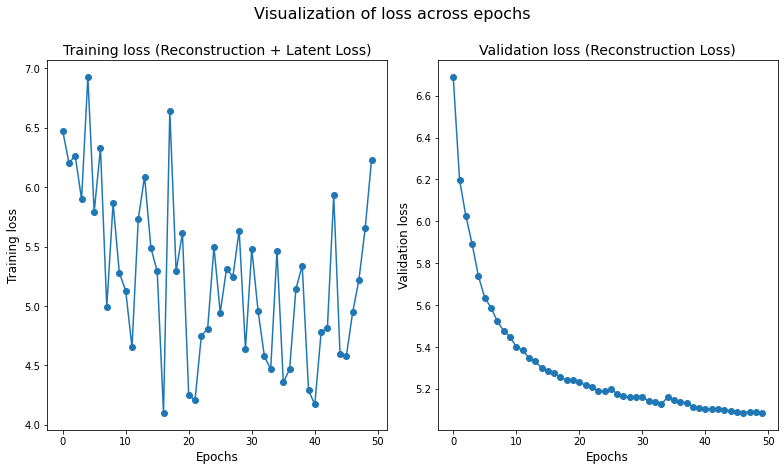

In [350]:
scRNA_loss(history_train, history_val)

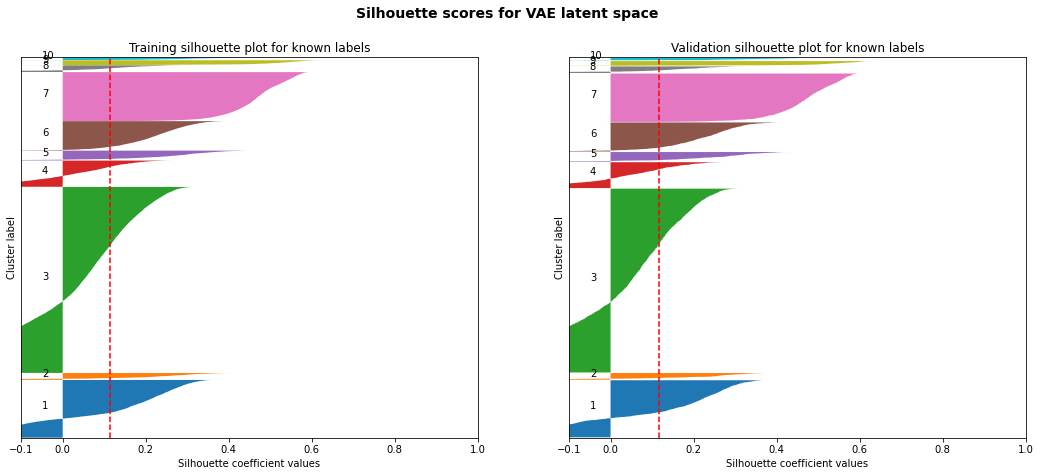

In [351]:
scRNA_silhouette(history_train, history_val, val_y , epoch_num=49)

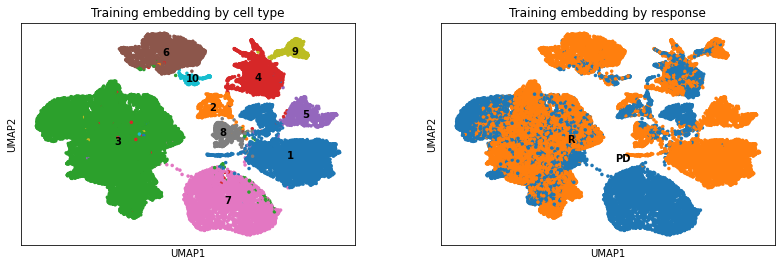

<ipython-input-177-99b1f55c5329>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['dbscan'] = pd.Categorical(val_adata.obs['dbscan'])
<ipython-input-177-99b1f55c5329>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
<ipython-input-177-99b1f55c5329>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

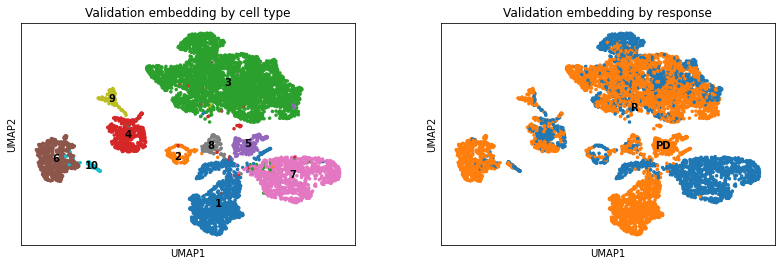

In [352]:
scRNA_latent(history_train, history_val, val_y , epoch_num=49)

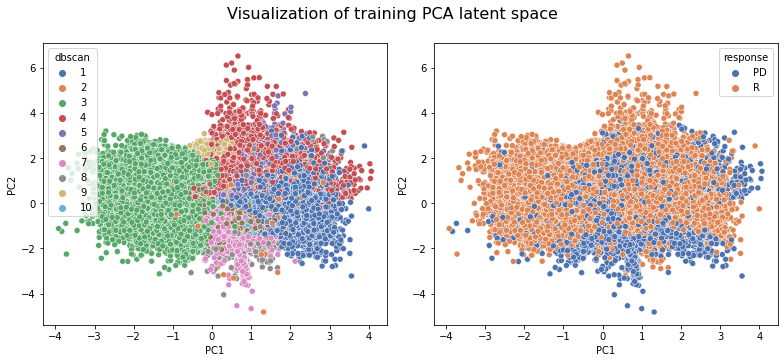

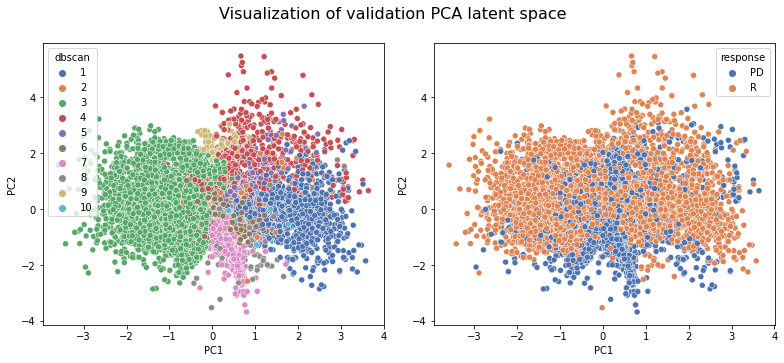

In [353]:
scRNA_latent_pca(history_train, history_val, val_y , epoch_num=49)

In [354]:
feature_importance(history_weight, 49)

PC1 top 5 loading genes


,gene
364,GNLY
1767,AL390294.1
2108,GZMB
2916,LGALS1
2175,WARS


,gene
71,DIO1
2711,AC011472.1
735,CXCL13
917,C5orf46
234,MYOC


PC2 top 5 loading genes


,gene
2121,RPS29
1037,RPS18
163,RPS27
1690,CCND1
2173,BCL11B


,gene
364,GNLY
2108,GZMB
1567,MSANTD3-TMEFF1
234,MYOC
2985,AL592528.1


In [357]:
num_epochs=100
batch_size=64
n_latent=50

model_adam = initialize_model(train_x, n_latent, optimizer = 'Adam',
                              learning_rate = 1e-3, 
                              lambda_latent = 1e-2, 
                              lambda_reconst = 1e-3)

history_train , history_val , history_weight= scRNA_train(model_adam, 
                                                          train_x, train_y, 
                                                          val_x, val_y ,
                                                          num_epochs, batch_size)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6.942200183868408, Validation loss: 6.648442268371582
Epoch: 1, Train loss: 5.8682050704956055, Validation loss: 6.191284656524658
Epoch: 2, Train loss: 6.134199142456055, Validation loss: 6.0087761878967285
Epoch: 3, Train loss: 6.580445289611816, Validation loss: 5.859277248382568
Epoch: 4, Train loss: 6.276119709014893, Validation loss: 5.769060134887695
Epoch: 5, Train loss: 5.603381156921387, Validation loss: 5.6585211753845215
Epoch: 6, Train loss: 5.91063117980957, Validation loss: 5.597464561462402
Epoch: 7, Train loss: 5.88300085067749, Validation loss: 5.542125225067139
Epoch: 8, Train loss: 6.7776899337768555, Validation loss: 5.494083881378174
Epoch: 9, Train loss: 4.723759651184082, Validation loss: 5.4585490226745605
Epoch: 10, Train loss: 6.0581464767456055, Validation loss: 5.435966491699219
Epoch: 11, Train loss: 5.415701389312744, Validation loss: 5.409884452819824
Epoch: 12, Train loss: 5.108795166015625, Validation loss: 5.3713483810424805
Epoc

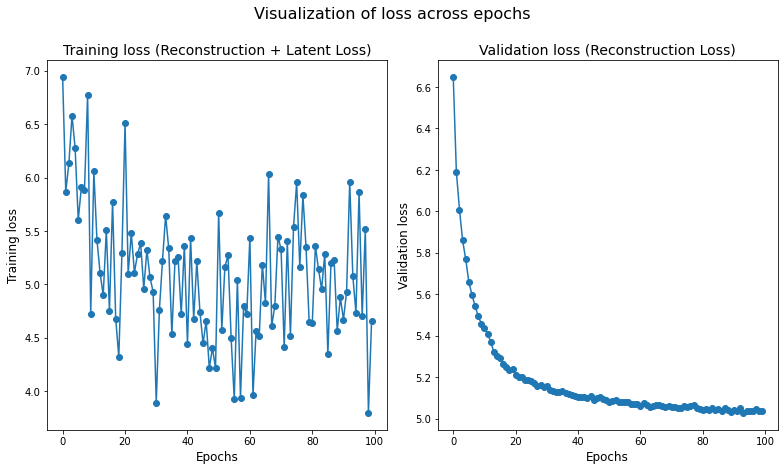

In [358]:
scRNA_loss(history_train, history_val)

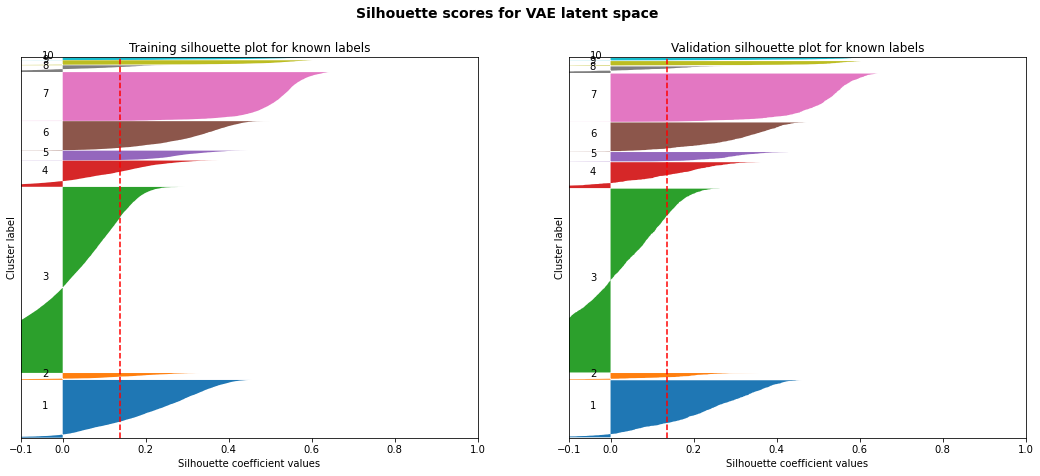

In [359]:
scRNA_silhouette(history_train, history_val, val_y , epoch_num=99)

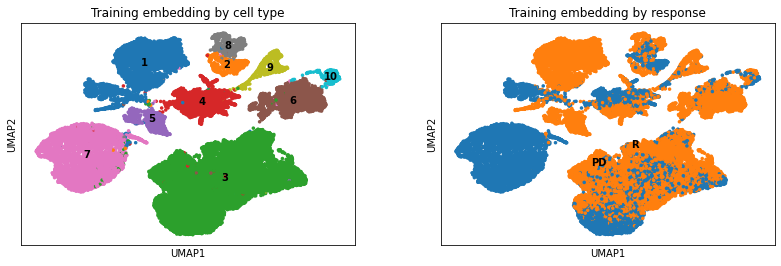

<ipython-input-177-99b1f55c5329>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['dbscan'] = pd.Categorical(val_adata.obs['dbscan'])
<ipython-input-177-99b1f55c5329>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
<ipython-input-177-99b1f55c5329>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

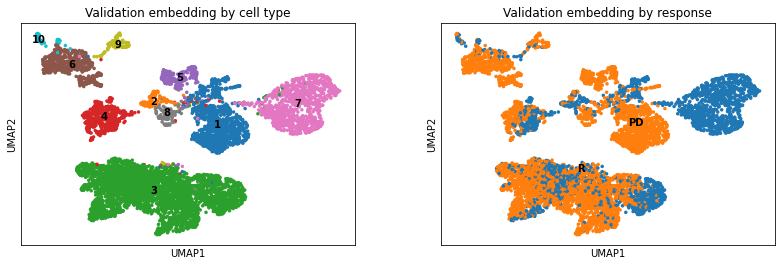

In [360]:
scRNA_latent(history_train, history_val, val_y , epoch_num=99)

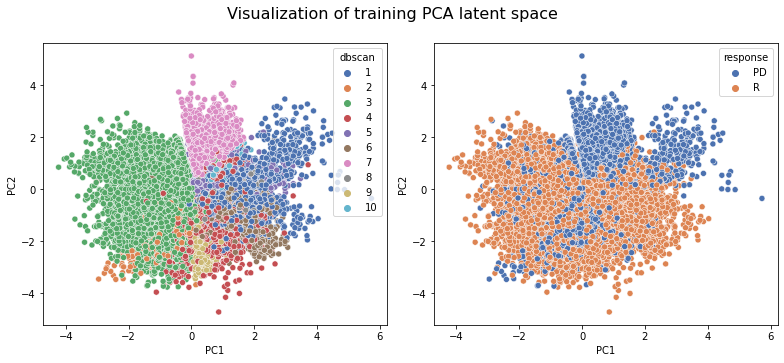

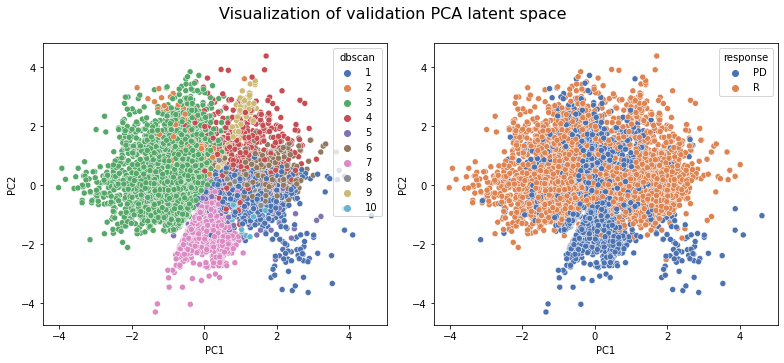

In [361]:
scRNA_latent_pca(history_train, history_val, val_y , epoch_num=99)

In [362]:
feature_importance(history_weight, 99)

PC1 top 5 loading genes


,gene
234,MYOC
1037,RPS18
712,ADGRL3
917,C5orf46
352,CD207


,gene
2994,MT-CO3
1082,MARCKS
1610,IFITM3
711,IGFBP7
2985,AL592528.1


PC2 top 5 loading genes


,gene
1730,CRYAB
1338,PAGE1
2990,MT-ND2
2997,MT-CYB
1916,MGP


,gene
1567,MSANTD3-TMEFF1
1453,AC113145.1
234,MYOC
2456,CCL5
2985,AL592528.1
